In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
import xscale
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from dask import compute, delayed

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(24)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.66:47749 Dashboard: http://10.148.1.66:8787/status,Cluster Workers: 14 Cores: 196 Memory: 840.00 GB


_________
# 1. Read dataset


In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

# read rechunked data
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_D = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

# buoyancy
ds_B = -9.81*(ds_D.Pden-25)/1025
ds_B = np.real(ds_B).rename('Buoy')
ds_B = ds_B.to_dataset()

# data merge
ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_D,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [7]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 .

In [8]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [9]:
out_dir_filter = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)

ds_U_lowpass = xr.open_zarr(out_dir_filter+'U_lowpass_filter_1day_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_filter+'V_lowpass_filter_1day_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_filter+'W_lowpass_filter_1day_rechunk.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_filter+'B_lowpass_filter_1day_rechunk.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])
print(ds_filter)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC           (lat, lon_g) float32 1567.638 1567.638 ... 1489.2013 1489.2013
    dyG           (lat, lon_g) float32 1468.5818 1468.5818 ... 1403.369 1403.369
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2302204.5 2302204.5 ... 2089899.0
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dxG           (lat_g, lon) float32 1567.8346 1567.8346 ... 1489.3967
    dyC           (lat_g, lon) float32 1468.746 1468.746 ... 1403.5306 1403.5306
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rAs           (lat_g, 

In [9]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/filtered_uv_data/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_30h_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_30h_filter_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_30h_filter_rechunk.zarr')
ds_P_lowpass = xr.open_zarr(out_dir_zarr+'P_lowpass_30h_filter_rechunk.zarr')

# buoyancy
ds_B_lowpass = -9.81*(ds_P_lowpass.B_low_filter-25)/1025
ds_B_lowpass = np.real(ds_B_lowpass).rename('B_low_filter')
ds_B_lowpass = ds_B_lowpass.to_dataset()

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 40, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 8761)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
    dxC           (lat, lon_g) float32 1567.638 1567.638 ... 1489.2013 1489.2013
    dyG           (lat, lon_g) float32 1468.5818 1468.5818 ... 1403.369 1403.369
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2302204.5 2302204.5 ... 2089899.0
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
    dxG           (lat_g, lon) float32 1567.8346 1567.8346 ... 1489.3967
    dyC           (lat_g, lon) float32 1468.746 1468.746 ... 1403.5306 1403.5306
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rAs           (lat_g, lon) float32 23

# 2. Vertical gradient

## 2.1 db/dz (i.e., $N^2$)
### note that -1* is necessary to make the sign correct ####

In [31]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
print(db_dz)

<xarray.DataArray 'mul-d9fb83a187b99c309d856f6e2b9b1276' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 177)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


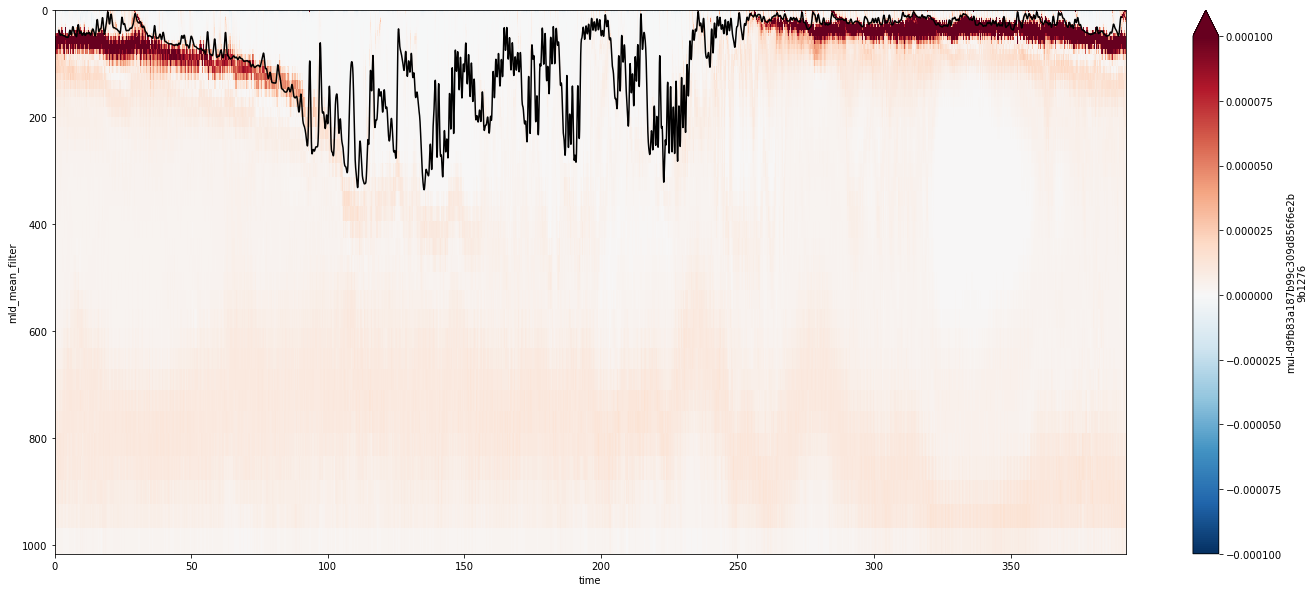

In [32]:
fig = plt.figure(figsize=(24,10))
db_dz.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.0001,vmax=0.0001,cmap='RdBu_r', yincrease=False) # lat=100 & lon=100 is a location near the mooring site
mld_mean_filter.plot(x='time',yincrease=False, color='black')

## 2.2 du/dz

In [10]:
dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')
print(dU_dz_ij)

<xarray.DataArray 'mul-839860478b2092d29095fbee9690e90f' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<shape=(9415, 52, 201, 177), dtype=float64, chunksize=(9415, 1, 201, 176)>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float64 47.4 47.42 47.43 47.44 47.46 47.47 47.48 47.5 ...
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 -17.91 ...


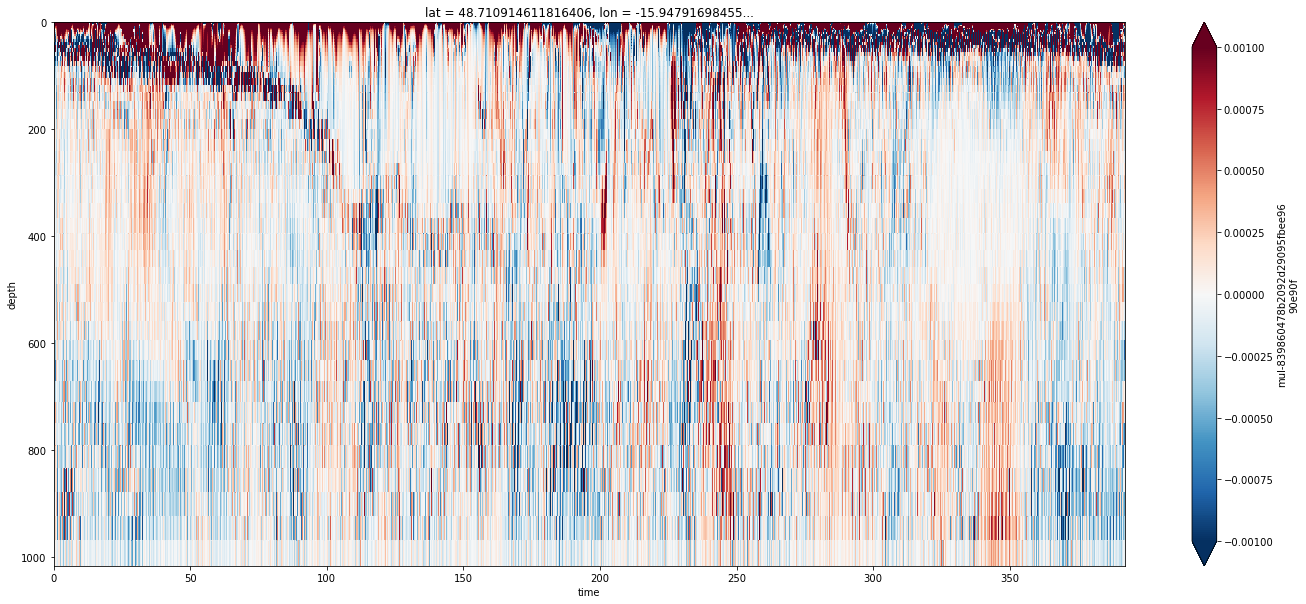

In [11]:
fig = plt.figure(figsize=(24,10))
dU_dz_ij.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.001,vmax=0.001,cmap='RdBu_r', yincrease=False)
mld_mean_filter.plot(x='time',yincrease=False, color='black')

____________
# 3. Geostrphic shear production (GSP)

## $GSP = -\overline{u_h'w'} \cdot (\partial \overline{u_h}/\partial z)$ with $u_h = (u,v)$

## 3.1 define perturbation (e.g., u', v')

In [13]:
w_mean = ds.W.mean(['lat','lon']) # spatial mean
b_mean = ds.Buoy.mean(['lat','lon'])
u_mean = ds.U.mean(['lat','lon_g'])
v_mean = ds.V.mean(['lat_g','lon'])

w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean
u_prime = ds.U - u_mean
v_prime = ds.V - v_mean

u_prime_ij = gridx.interp(u_prime,'X') # interplate into the cell center (i, j or lon, lat)
u_prime_ij

v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')

dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')

vsp = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime * v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp

store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
chunks = {'time': 9415, 'depth':1}
vsp = vsp.chunk(chunks)
vsp = np.real(vsp).rename('vsp')
vsp = vsp.to_dataset()
print(vsp)
file_out = store_dir_zarr+'/vsp_rechunk.zarr'
%time vsp.to_zarr(file_out, mode='w')  


<xarray.Dataset>
Dimensions:  (depth: 52, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dzt      (depth) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    vsp      (time, depth) float64 dask.array<chunksize=(9415, 1), meta=np.ndarray>
CPU times: user 15 s, sys: 1.17 s, total: 16.2 s
Wall time: 2min 21s


In [14]:
w_mean = ds_filter.W_low_filter.mean(['lat','lon']) # spatial mean
b_mean = ds_filter.B_low_filter.mean(['lat','lon'])
u_mean = ds_filter.U_low_filter.mean(['lat','lon_g'])
v_mean = ds_filter.V_low_filter.mean(['lat_g','lon'])

w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean
u_prime = ds_filter.U_low_filter - u_mean
v_prime = ds_filter.V_low_filter - v_mean

u_prime_ij = gridx.interp(u_prime,'X') # interplate into the cell center (i, j or lon, lat)
u_prime_ij

v_prime_ij = gridx.interp(v_prime,'Y')
v_prime_ij

dU_dz_left = -1*gridx.diff(ds_filter.U_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz_ij = gridx.interp(dU_dz,'X')

dV_dz_left = -1*gridx.diff(ds_filter.V_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz_ij = gridx.interp(dV_dz,'Y')

vsp_filter = -1*((w_prime * u_prime_ij).mean(['lat','lon']) * dU_dz_ij.mean(['lat','lon']) + (w_prime * v_prime_ij).mean(['lat','lon']) * dV_dz_ij.mean(['lat','lon']))
vsp_filter

store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
chunks = {'time': 9415, 'depth':1}
vsp_filter = vsp_filter.chunk(chunks)
vsp_filter = np.real(vsp_filter).rename('vsp_filter')
vsp_filter = vsp_filter.to_dataset()
print(vsp_filter)
file_out = store_dir_zarr+'/vsp_rechunk_filter.zarr'
%time vsp_filter.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:     (depth: 52, time: 9415)
Coordinates:
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    vsp_filter  (time, depth) float64 dask.array<chunksize=(9415, 1), meta=np.ndarray>
CPU times: user 17.6 s, sys: 1.46 s, total: 19.1 s
Wall time: 2min 54s


In [15]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
vsp = xr.open_zarr(store_dir_zarr+'vsp_rechunk.zarr')
vsp_filter = xr.open_zarr(store_dir_zarr+'vsp_rechunk_filter.zarr')

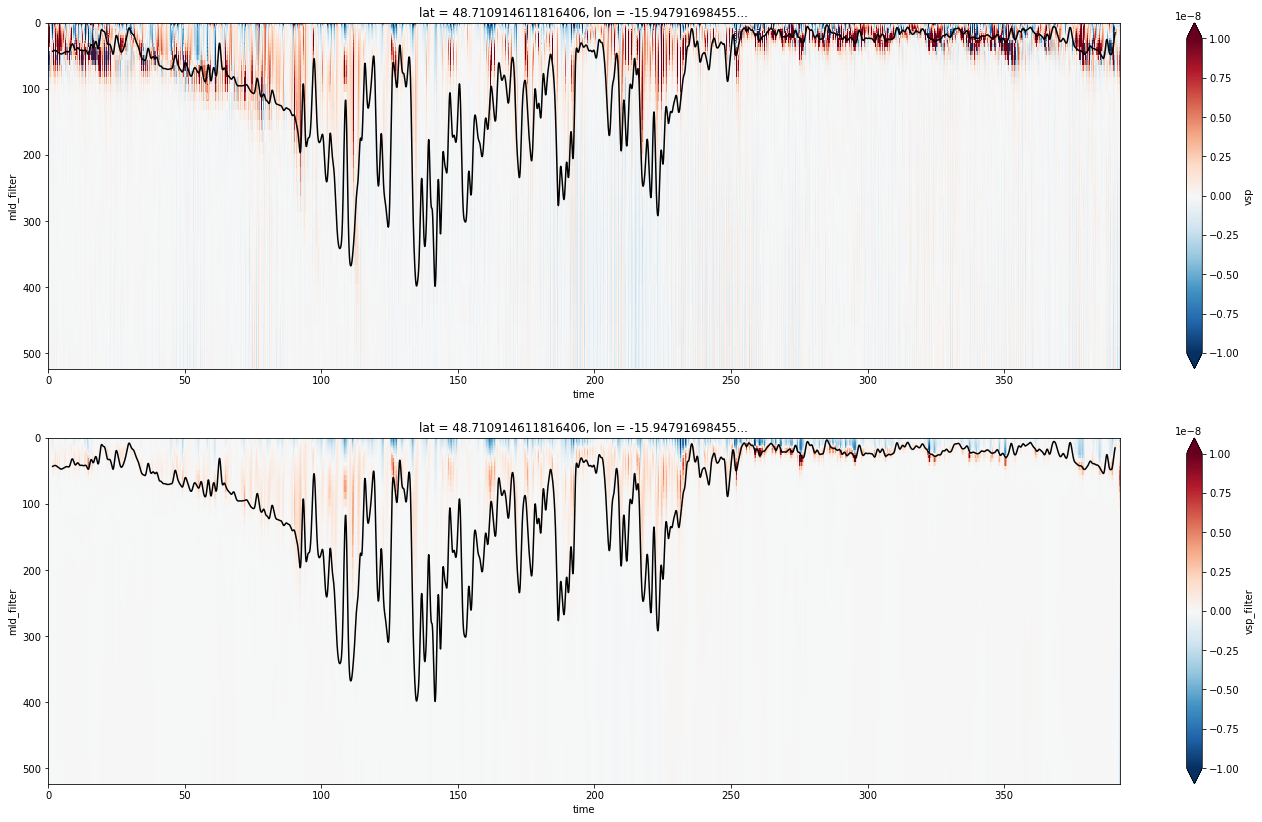

In [19]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
vsp.vsp.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
vsp_filter.vsp_filter.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

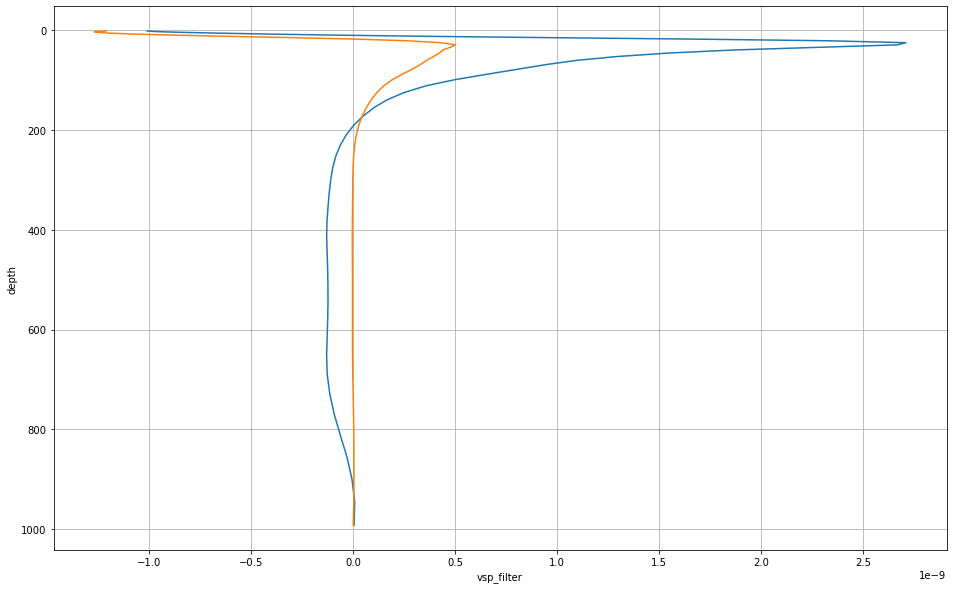

In [20]:
fig, ax = plt.subplots(figsize=(16,10))
vsp.vsp.mean('time').plot(y='depth', yincrease=False)
vsp_filter.vsp_filter.mean('time').plot(y='depth', yincrease=False)
ax.grid()

# 5.  vertical buoyancy flux w'b'

In [14]:
w_mean = ds_filter.W_low_filter.mean(['lat','lon']) # spatial mean
b_mean = ds_filter.B_low_filter.mean(['lat','lon'])
w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean

wb_prime_filter = (w_prime*b_prime)
wb_prime_filter

<xarray.DataArray (time: 8761, depth: 40, lat: 201, lon: 177)>
dask.array<mul, shape=(8761, 40, 201, 177), dtype=float32, chunksize=(8761, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 410.4 441.3 473.3 506.5
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ... 2012-09-12
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    CS       (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Depth    (lat, lon) float32 4658.816 4647.708 4628.1807 ... 4070.18 4057.071
    SN       (lat, lon) float32 -2.519282e-13 -0.0 ... -2.651958e-13
    XC       (lat, lon) float32 -18.03125 -18.010416 ... -14.385417 -14.364583
    YC       (lat, lon) float32 47.404716 47.404716 ... 49.98778 49.98778
    rA       (lat, lon) float32 2302204.5 2302204.5 ... 2089898.9 2089898.9

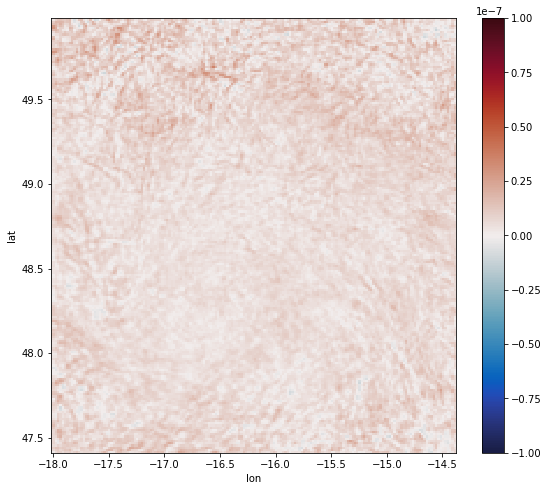

In [18]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
wb_prime_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=slice(0,40)).mean(['depth','time']).plot(x='lon', y='lat', vmin=-1e-7,vmax=1e-7, cmap=cm.balance)

In [18]:
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
ds = ds.chunk(chunks)

w_mean = ds.W.mean(['lat','lon']) # spatial mean
b_mean = ds.Buoy.mean(['lat','lon'])
w_prime = ds.W - w_mean
b_prime = ds.Buoy - b_mean

wb_prime = (w_prime*b_prime).mean(['lat','lon'])
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/'

chunks = {'time': 9415, 'depth':1}
wb_prime = wb_prime.chunk(chunks)
wb_prime = np.real(wb_prime).rename('wb_prime')
wb_prime = wb_prime.to_dataset()
print(wb_prime)
file_out = store_dir_zarr+'/wb_prime_rechunk.zarr'
%time wb_prime.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:   (depth: 52, time: 9415)
Coordinates:
  * depth     (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time      (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
    dzt       (depth) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    wb_prime  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>


KilledWorker: ("('real-rechunk-merge-24a7d19c2aa0da7275a38e4be277e19b', 0, 4, 0, 0)", <Worker 'tcp://10.148.0.247:49729', memory: 0, processing: 14>)

In [12]:
w_mean = ds_filter.W_low_filter.mean(['lat','lon']) # spatial mean
b_mean = ds_filter.B_low_filter.mean(['lat','lon'])
w_prime = ds_filter.W_low_filter - w_mean
b_prime = ds_filter.B_low_filter - b_mean

wb_prime_filter = (w_prime*b_prime).mean(['lat','lon'])

store_dir_store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/'
chunks = {'time': 9415, 'depth':1}
wb_prime_filter = wb_prime_filter.chunk(chunks)
wb_prime_filter = np.real(wb_prime_filter).rename('wb_prime_filter')
wb_prime_filter = wb_prime_filter.to_dataset()
print(wb_prime_filter)
file_out = store_dir_zarr+'/wb_prime_rechunk_filter.zarr'
%time wb_prime_filter.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:          (depth: 40, time: 8761)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-09-12
Data variables:
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(8761, 1), meta=np.ndarray>
CPU times: user 1min 38s, sys: 5.66 s, total: 1min 44s
Wall time: 3min 45s


In [24]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
wb_prime = xr.open_zarr(store_dir_zarr+'wb_prime_rechunk.zarr')
wb_prime_filter = xr.open_zarr(store_dir_zarr+'wb_prime_rechunk_filter.zarr')

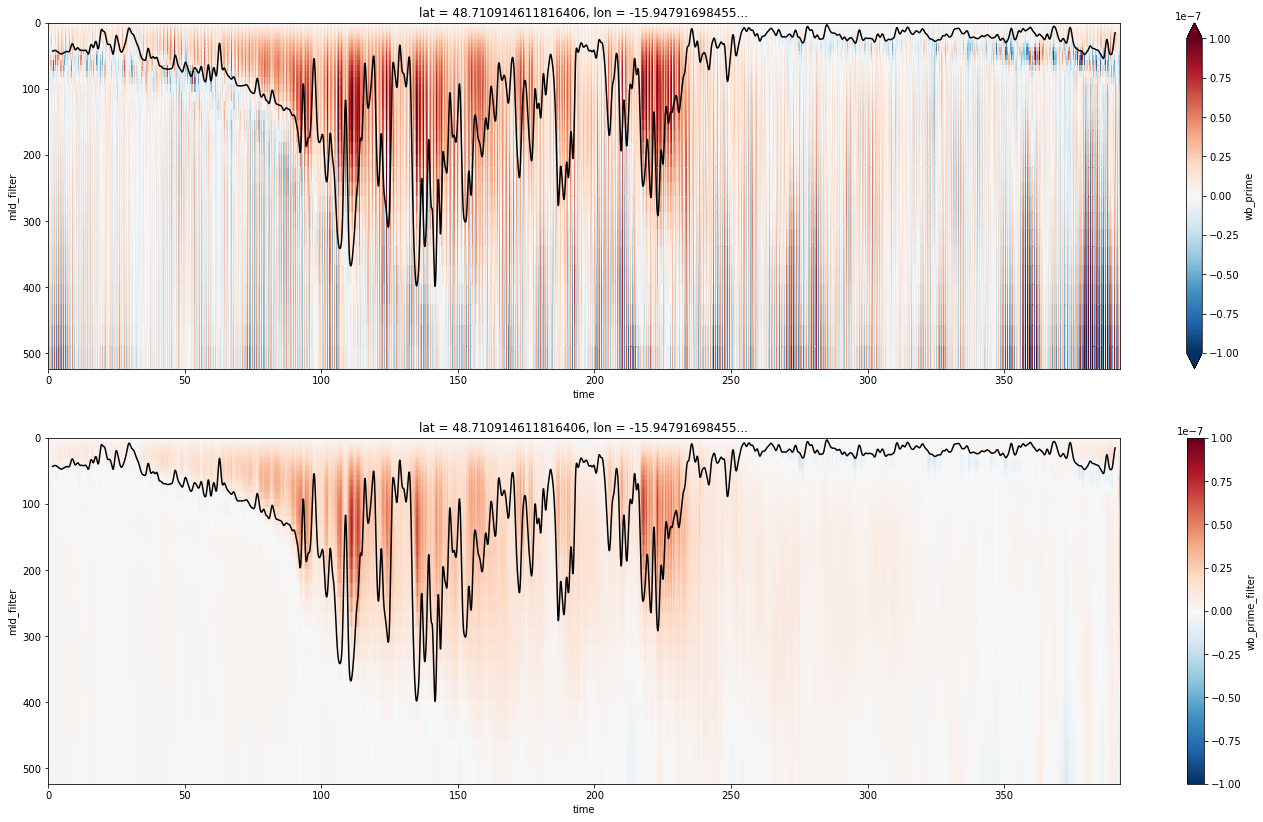

In [26]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
wb_prime.wb_prime.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
wb_prime_filter.wb_prime_filter.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

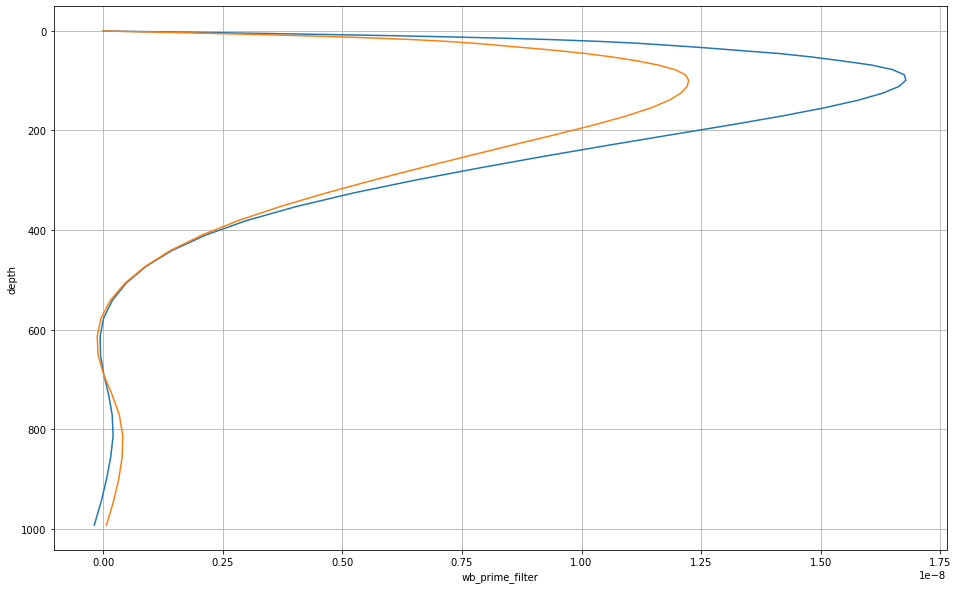

In [39]:
fig, ax = plt.subplots(figsize=(16,10))

wb_prime.wb_prime.isel(time=slice(10,9400)).mean('time').plot(y='depth', yincrease=False)
wb_prime_filter.wb_prime_filter.isel(time=slice(10,9400)).mean('time').plot(y='depth', yincrease=False)
ax.grid()

# 6. GSP vs. w'b'

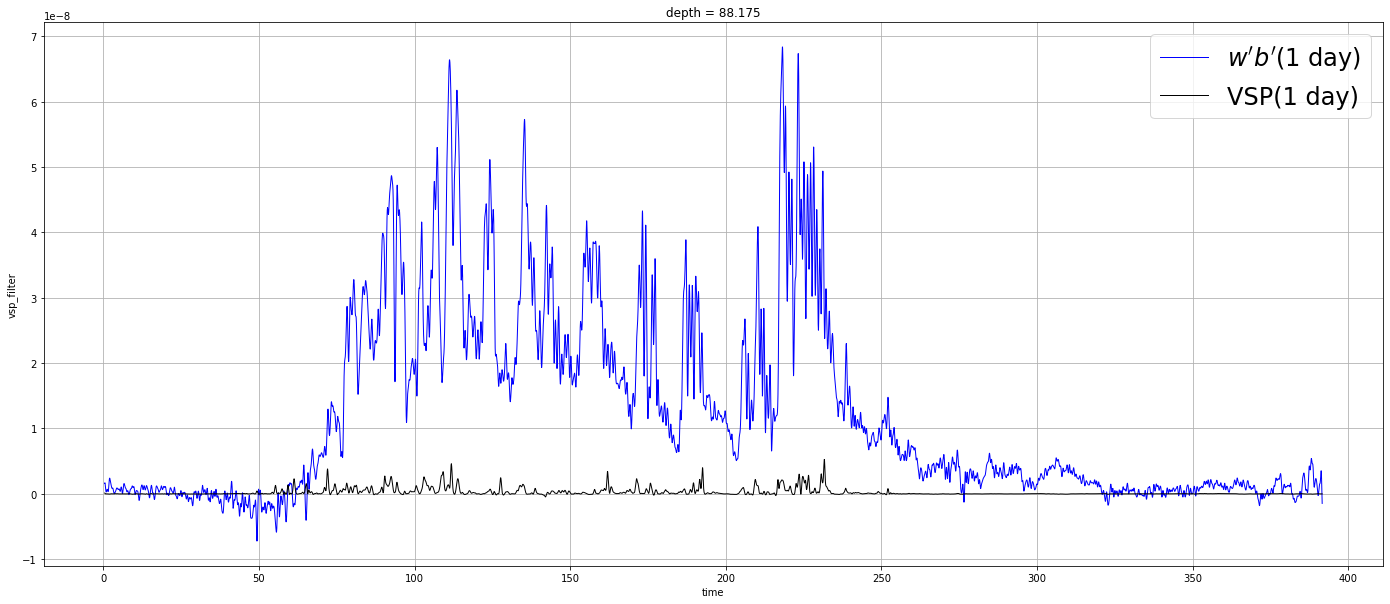

In [42]:
labels = ['VSP(1 day)', '$w^\prime b^\prime$(1 day)']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime_filter.wb_prime_filter.isel(depth=20,time=slice(10,9400)).plot(ax=ax, color='blue', label=labels[1], linewidth=1)
vsp_filter.vsp_filter.isel(depth=20,time=slice(10,9400)).plot(ax=ax, color='black', label=labels[0], linewidth=1)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

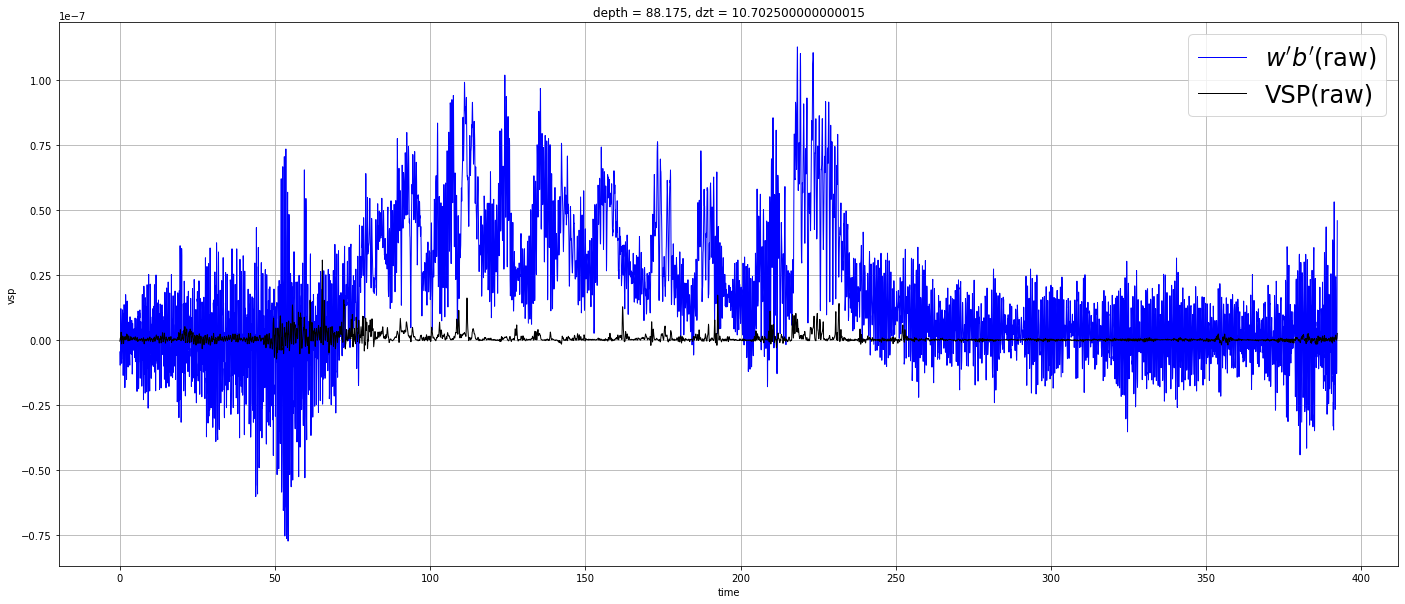

In [43]:
labels = ['VSP(raw)', '$w^\prime b^\prime$(raw)']

fig, ax = plt.subplots(figsize=(24,10))
wb_prime.wb_prime.isel(depth=20).plot(ax=ax, color='blue', label=labels[1], linewidth=1)
vsp.vsp.isel(depth=20).plot(ax=ax, color='black', label=labels[0], linewidth=1)
ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

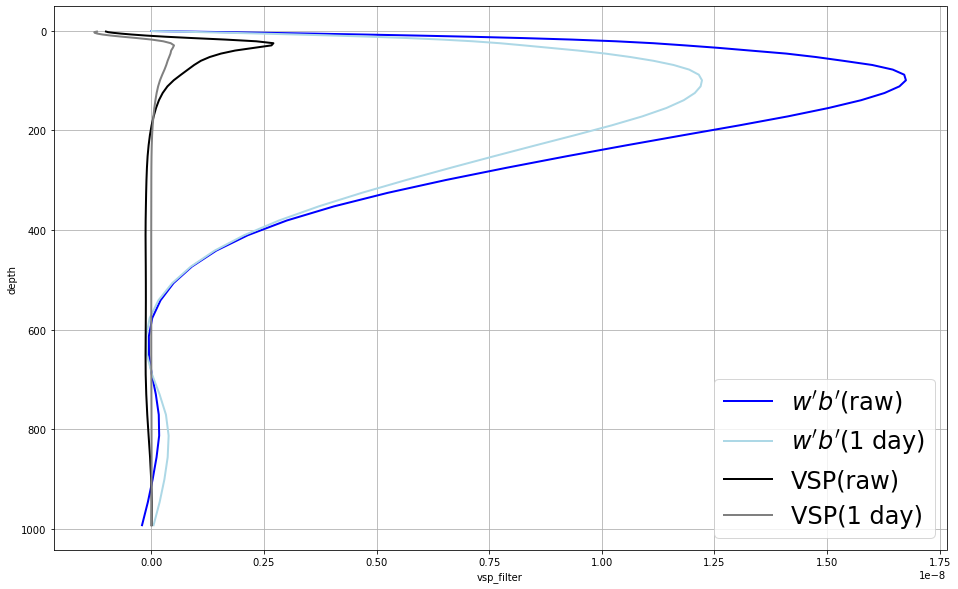

In [41]:
labels = ['VSP(raw)', '$w^\prime b^\prime$(raw)', 'VSP(1 day)', '$w^\prime b^\prime$(1 day)']

fig, ax = plt.subplots(figsize=(16,10))
wb_prime.wb_prime.mean('time').plot(ax=ax, color='blue', label=labels[1], linewidth=2, y='depth', yincrease=False)
wb_prime_filter.wb_prime_filter.mean('time').plot(ax=ax, color='lightblue', label=labels[3], linewidth=2, y='depth', yincrease=False)

vsp.vsp.mean('time').plot(ax=ax, color='black', label=labels[0], linewidth=2, y='depth', yincrease=False)
vsp_filter.vsp_filter.mean('time').plot(ax=ax, color='grey', label=labels[2], linewidth=2, y='depth', yincrease=False)

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})

In [20]:
cluster.close()

RuntimeError: Command exited with non-zero exit code.
Exit code: 35
Command:
qdel 8608347 8608344 8608338 8608341
stdout:

stderr:
qdel: Job has finished

